In [ ]:
import csv
import html
import subprocess

table = "../../results/03_dedup/summary_table"

html_top = """
<html>
  <head>
  <title>Ips PoolSeq QC report</title>
  <link rel="icon" type="image/png" href="favicon_sbb.png">
    <style>
      tr:nth-child(odd) { background-color: #fff; }
      tr:nth-child(even) { background-color: #f2f2f2; }

      table { border-collapse: collapse; width: auto; }

      th, td {
        border: 1px solid #ccc;
        text-align: center;
        vertical-align: middle;
        font-size: 14px;
        padding: 5px 6px;
      }
      th { background-color: #ddd; border-color: #bbb; }
      img { max-width: 300px; height: auto; }
      body { font-family: sans-serif; font-size: 14px; }
      .top_header { background-color: #d3d3d3; padding: 6px; border-color: #bbb; }
      .title { font-family: sans-serif; font-size: 18px; font-weight: bold; }
      .legend {border:1px solid #ccc; margin-right:6px; display:inline-block; width:12px; height:12px;align-items: center;}
    </style>   
  </head>
  <body>
<br><br><span class="title">Mapping output, before and after deduplication.<br><br></span>


  
  <div style="display: flex; gap: 16px; align-items: center; font-family: sans-serif;">
    <div><span><strong>Mean depth:</strong></span></div>
    <div><span class="legend"; style="background:#ff9999;"></span> 0 - 100</div>
    <div><span class="legend"; style="background:#ffcc99;"></span> 100 - 200  </div>
    <div><span class="legend"; style="background:#ffffcc;"></span> 200 - 300 </div>
    <div><span class="legend"; style="background:#99ff99;"></span> > 300 </div>
  </div> 
  <br>
"""
#Columns in HTML table
#Idn Year	Time	Country	Region	Reps	Before After	Mapped Dedup Cov	Cov_mapped	Cov_dedup
out_html_report = "../../results/03_dedup/map_and_dedup.html"
#Open file for reading and for writing
with open(table) as tsvfile, open(out_html_report, "w") as out:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = list(reader)
    header = rows[0]
    data_rows = rows[1:]    
    
    #Write HTML top and css
    out.write(html_top)

    #Write table header
    out.write("<table border='1'>\n")
    out.write("  <thead><tr>\n")
    for col in header:
        out.write(f"<th>{html.escape(col)}</th>\n")
    out.write("<th>Depth</th>\n")
    out.write("<th>Insertion size</th>\n")
    out.write("</tr></thead>\n")

    #Write table body
    out.write("<tbody>\n")
    for row in data_rows:
        out.write("<tr>\n")
        for col_idx, col in enumerate(row):
            if col_idx in [10, 11]:  # columns 11 and 12 with cov_cell class for color
                out.write(f'<td class="cov_cell">{html.escape(col)}</td>\n')
            else:
                out.write(f"<td>{html.escape(col)}</td>\n")
        # Add image cell
        sample_id = row[0]  #get prefix for plot files

        depth_img = f"./depth/{sample_id}.depth.500K_bins.png"
        out.write(f' <td><img src="{depth_img}" alt="{depth_img}"></td>\n')

        insertion_size_img = f"./insertion_size_metrics/{sample_id}.dedup.sort.insertion_metrics_histogram.png"
        out.write(f'<td><img src="{insertion_size_img}" width="160px"></td>\n')
        out.write("</tr>\n")
    out.write("</tbody>\n</table>\n")

#Add JS script for coloring:
    out.write("""
<script>
  document.querySelectorAll('td.cov_cell').forEach(function(cov) {
    let val = parseFloat(cov.textContent);
    if (!isNaN(val)) {
      if (val < 100) {
        cov.style.backgroundColor = '#ff9999';
      } else if (val < 200) {
        cov.style.backgroundColor = '#ffcc99';
      } else if (val < 300) {
        cov.style.backgroundColor = '#ffffcc';
      } else {
        cov.style.backgroundColor = '#99ff99';
      }
    }
  });
</script>
""")


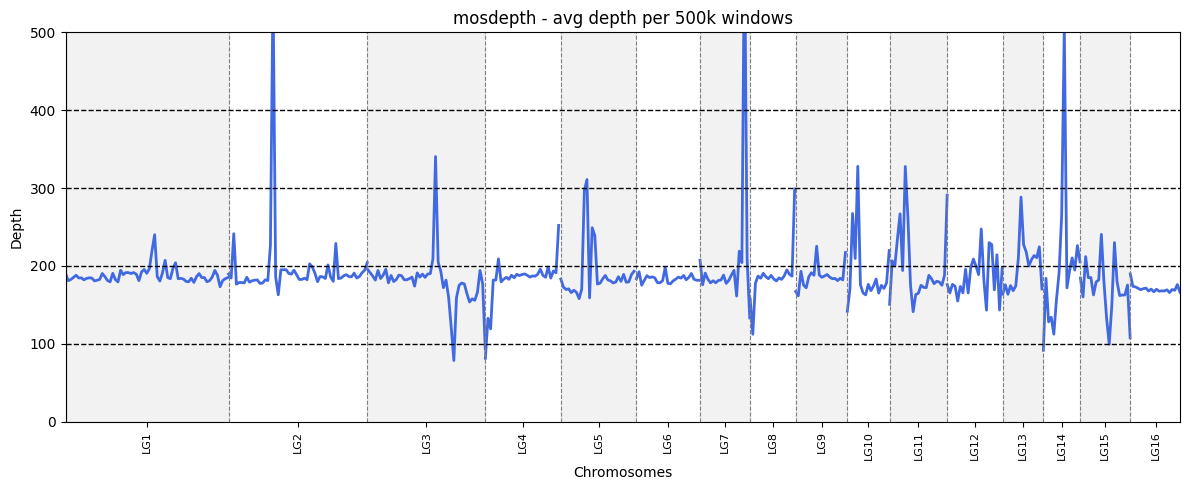

In [23]:
#----------------------------------------------------------------------
# Make mosdepth plots per genomic window for the html map & dedup report.
# In: *.mosdepth.regions.bed.gz
# Ouput lineplots of depth average per bin.
#----------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Set working directory and load data
wd = "../../results/03_dedup/"

def plot(filepath, outplot):
    df = pd.read_csv(filepath, sep='\t', header=None,
                    names=["chrom", "start", "end", "depth"])

    # Sort by contig and start, keep only chromo
    df = df[df["chrom"].str.startswith("LG")]    
    df.sort_values(by=["chrom", "start"], inplace=True)

    # Get  contig lengths
    contig_lengths = df.groupby("chrom")["end"].max().to_dict()
    contigs_sorted = sorted(contig_lengths.keys(), key=lambda x: int(x.replace("LG", "")))

    # Compute cumulative offsets
    offsets = {}
    current_offset = 0
    for contig in contigs_sorted:
        offsets[contig] = current_offset
        current_offset += contig_lengths[contig]

    # Add cumulative start positions
    df["cum_start"] = df.apply(lambda row: row["start"] + offsets[row["chrom"]], axis=1)

    
    ylim_max = 500
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot basic settings
    ax.set_xlim(0, df["cum_start"].max())
    ax.set_ylim(0, ylim_max)
    ax.set_xlabel("Chromosomes")
    ax.set_ylabel("Depth")
    title = filepath.split("/")[4].split(".")[0]
    ax.set_title(title + " - avg depth per 500k windows")

    # 2. Alternate background colors
    for i, contig in enumerate(contigs_sorted):
        start = offsets[contig]
        end = start + contig_lengths[contig]
        if i % 2 == 0:
            ax.axvspan(start, end, color=(0.9, 0.9, 0.9, 0.5))

    # 3. Plot depth lines
    for contig in contigs_sorted:
        sub_df = df[df["chrom"] == contig]
        ax.plot(sub_df["cum_start"], sub_df["depth"], color="royalblue", linewidth=2)

    #Add contig boundary lines
    for contig in contigs_sorted:
        ax.axvline(x=offsets[contig], color="gray", linestyle="dashed", linewidth=0.8)

    #Add vertical line at end of last contig
    last_contig = contigs_sorted[-1]
    end_last_contig = offsets[last_contig] + contig_lengths[last_contig]
    ax.axvline(x=end_last_contig, color="gray", linestyle="dashed", linewidth=0.8)

    # X-axis labels at contig midpoints
    midpoints = [offsets[c] + contig_lengths[c] / 2 for c in contigs_sorted]
    ax.set_xticks(midpoints)
    ax.set_xticklabels(contigs_sorted, rotation=90, fontsize=8)

    # Horizontal dashed lines in y axis
    ax.axhline(y=400, color="black", linestyle="dashed", linewidth=1)
    ax.axhline(y=300, color="black", linestyle="dashed", linewidth=1)
    ax.axhline(y=200, color="black", linestyle="dashed", linewidth=1)
    ax.axhline(y=100, color="black", linestyle="dashed", linewidth=1)

    # Final layout
    plt.style.use('default')
    plt.tight_layout()    
    plt.savefig(outplot, dpi=300)
    #plt.show()

#Start call here
files = glob.glob("../../results/03_dedup/mosdepth/LAAU_Ea_2023.mosdepth.regions.bed.gz")
for i in files:    
    outplot = i.replace("mosdepth.regions.bed.gz", "depth.500K_bins.png").replace("mosdepth","depth")
    plot(i, outplot)



In [54]:
#----------------------------------------------------------------------
# Build barplots of expected coverage depths grouped by: sample, country,
# regions, season and ordered by year using the report of mappings and dedups.
# In:  summary_table
# Out: grouped barplots  comarping mapped and dedups for each sample
#----------------------------------------------------------------------

out_dir="../../results/03_dedup/barplots/"

for plot_id in plot_ids:
    fig, ax = plt.subplots(figsize=(10, 4))

    # Subset and full merge
    subset = df_melted[df_melted["Plot_ID"] == plot_id]
    full_index = pd.MultiIndex.from_product(
        [all_years, all_reps, all_coverage_types],
        names=["Year", "Rep", "CoverageType"]
    )
    full_df = pd.DataFrame(index=full_index).reset_index()
    full_df["Plot_ID"] = plot_id
    merged = pd.merge(
        full_df, subset,
        on=["Plot_ID", "Year", "Rep", "CoverageType"],
        how="left"
    )
    merged["Coverage"] = merged["Coverage"].fillna(0)

    # Pivot for bar plotting
    pivot = merged.pivot_table(
        index=["Year", "Rep"],
        columns="CoverageType",
        values="Coverage"
    ).reset_index()

    pivot = pivot.sort_values(["Year", "Rep"])
    labels = pivot["Year"].astype(str) + "_" + pivot["Rep"]
    x = range(len(pivot))
    width = 0.35

    ax.bar([i - width/2 for i in x], pivot["Cov_mapped"], width=width, label="Depth_no_dedup", color="peru")
    ax.bar([i + width/2 for i in x], pivot["Cov_dedup"], width=width, label="Depth_dedup", color="darkkhaki")

    country = plot_id.split("_")[1]
    region = plot_id.split("_")[2]
    time = plot_id.split("_")[0]
    ax.set_title(f"{region}{country}_{time}")
    ax.set_ylabel("Depth")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylim(0, 400)
    ax.axhline(100, color='gray', linestyle='--')
    ax.axhline(200, color='gray', linestyle='--')
    ax.axhline(300, color='gray', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{out_dir}{region}{country}_{time}.png", dpi=300)
    plt.close()




